# galaxySLED notebook

## What do you need it for
We developed a code to estimate the CO emission in AGN-host galaxies. The underlying model is described in [Esposito et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.8727E/abstract), and it has been tested with the data presented in [Esposito et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512..686E/abstract).

#### What you have to input
To produce the baseline CO SLED you need to feed the code with:
- The molecular gas mass of your object
- The optical radius
- The intrinsic nuclear X-ray luminosity
- The three Sersic parameters for the FUV flux (or the SFR)

With these input data, the code will produce the expected CO SLED of your object.

If you already have the luminosity of some CO lines, you can make the baseline model fit the observed data.
Input the CO luminosities with their errors, it works with upper limits as well.
The output will be:
- The best-fit CO SLED, up to CO(30-29)
- The best-fit CO-to-H2 conversion factor $\alpha_{CO}$
- The best-fit X-ray attenuation column density $N_H$

### Table of contents

#### How to run the code

1. [Import packages and modules](#import)
2. [Input data and parameters](#input)
3. [Fill the galaxy of GMCs (or import a file if you already did it)](#fill)
4. [Generate the baseline CO SLED](#baseline)
5. [Fit the baseline model to a observed CO SLED](#fit)

#### Appendices
1. [Available GMCs](#gmcs)
2. [Check the slope of the GMC fill-up procedure](#slope)

<a id='import'></a>

## Import packages and modules

In [1]:
# import galaxySLED
import galaxysled as gs

# import libraries to run this notebook (installed by default with galaxySLED)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plot resolution
%matplotlib inline
plt.rcParams['figure.dpi'] = 130

# print python version to check
!python --version

# print kernel name to check
print('Jupyter is using the %s kernel' % os.path.basename(sys.executable.replace('/bin/python','')))

# get current directory
print('Current directory is %s' % os.getcwd())

Python 3.9.6
Jupyter is using the galaxysled_dev kernel
Current directory is /Users/fesposito/astro/projects/galaxysled/galaxysled/docs


<a id='input'></a>

## Input data and parameters

Here you have to input the needed data and parameters for the code to work.

The following are the data for your object:
- `Mmol_tot` is the total molecular mass of the object
- `r25` is the optical radius of the object (technically the length of the projected major axis at the isophotal level 25 mag/arcsec$^2$ in the B-band): the molecular scale-length is defined as $r_{CO} = 0.17 \, r_{25}$ (Boselli+14, Casasola+17, Esposito+22)
- `logLX` is the logarithm of the 2-10 keV luminosity in erg/s
- `FUVparams` are the 3 parameters of the Sersic function that describes the FUV flux within the object: intensity at $R_e$ (in erg/s/cm$^2$), $R_e$ (in kpc), and $n$, where $R_e$ is the effective radius); in case you do not have these, put the $\rm SFR$ in M$_{\odot}$ yr$^{-1}$ units, and the code will assume a flat $G_0 = \rm SFR$

Next are the model parameters:
- `outfolder` is the folder where you want the output to be saved
- `logR_end` is the logarithm of the final radius (in kpc) at which you want the molecular emergent flux to be computed (default is $2 \, r_{CO}$)
- `logR_step` is the radial step in log-scale (default is 0.05), so that the radius array is defined as `10**np.arange(0, logR_end, logR_step)`
- `a` is the power-law index of the GMC mass distribution: default is 1.64 (Roman-Duval+10, Esposito+24)
- `gmcs` is the list of modelled GMCs (default is `e24list`); at the moment the only available list is the `e24list`, described in Esposito et al. (2024); more on this list at the bottom of this notebook

Additional parameters are:
- `G0floor`: if `True` it sets a minimum $G_0=1$ even if the Sersic function $G_0(r)$ drops below it (default is `True`); if `False`, when $G_0(r)<1$ there will be no simulated PDRs (so no CO emission even if there are GMCs at those radii)
- `Jmax` is the maximum number of $J_{upp}$ for the CO SLED (default is 13, maximum available is 30)
- `ncores` is the number of CPU cores to use for the `gmc_fill` function, which could be taxing for your machine; default is `None`, which means the code will use all the available cores
- `verbose` set as `True` enables output messages in the terminal while executing the `gmc_fill` function (default is `False`)

In [2]:
# INPUT DATA

# galaxy data
Mmol_tot = 3.33e+10           # Msun
r25 = 13.76                   # kpc
logLX = 43.19                 # erg/s (2-10 keV)
FUVparams = 1.10, 1.35, 0.70  # erg/s/cm^2, kpc, [dimensionless]
SFR = 35                      # Msun/yr
FUVparams = SFR               # if you don't know the three FUV parameters

# script parameters (logR_step=1 for quick tests, you should use the commented value of 0.05 or similar)
outfolder = os.getcwd() + '/ngc7469/'
rCO = 0.17e3*r25           # pc
logR_end = np.log10(2*rCO) # 2*rCO [pc]
logR_step = 1              # 0.05
a = 1.64                   # GMC mass PL distribution index

# GMCs data
gmcs = gs.e24list

# additional parameters
G0floor = True
Jmax = 13
n_cores = None
verbose = True

<a id='fill'></a>

## Fill the galaxy with GMCs...

The `gmc_fill` function will fill the object volume and mass with the GMC distribution. If you want to leave some parameters as default, remove them from the list below. The function will produce a `GMCs_NradiiXX_aYY.csv` within the `outfolder` directory, where `XX` is the number of radii and `YY` is 100 times the power-law index `a`.

Note: next cell can take some time to be executed

In [4]:
# Careful: this will overwrite a previously saved csv file with the same name! 
#          Please rename the old file to preserve it

galdf = gs.gmc_fill(outfolder, Mmol_tot, r25, logR_end, logR_step, a, gmcs, n_cores, verbose)

The saved file will be /media/phd/hub/packaging/galaxysled/docs/ngc7469/GMCs_Nradii4_a164.csv


### ... or import a file if you already did it

If you already run the `gmc_fill` function you can directly import the result

In [3]:
galdf = pd.read_csv(outfolder + 'GMCs_Nradii74_a164.csv', index_col=0)
galdf

,r,V_r,M_r,N_e24_logM31,N_e24_logM33,N_e24_logM35,N_e24_logM37,N_e24_logM39,N_e24_logM41,N_e24_logM43,...,N_e24_logM49,N_e24_logM51,N_e24_logM53,N_e24_logM55,N_e24_logM57,N_e24_logM59,V_plugged,M_plugged,n_r,NH_r
0,1.000000,1.231052e+56,3.041976e+03,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000e+00,0.000000e+00,24097.974232,0.000000e+00
1,1.122018,5.078551e+55,7.875117e+02,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000e+00,0.000000e+00,21476.595312,8.580528e+21
2,1.258925,7.173645e+55,9.913635e+02,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000e+00,0.000000e+00,19140.288897,1.712227e+22
3,1.412538,1.013304e+56,1.247975e+03,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000e+00,0.000000e+00,17058.053676,2.570213e+22
4,1.584893,1.431330e+56,1.570998e+03,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000e+00,0.000000e+00,15202.259610,3.424312e+22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2818.382931,4.151077e+64,1.590054e+09,327007,153759,72108,33928,15961,7471,3521,...,365,168,76,37,16,8,1.427238e+63,1.590039e+09,54.565565,1.026111e+24
70,3162.277660,5.225896e+64,1.742008e+09,357619,168206,78973,37220,17436,8197,3850,...,390,190,81,42,17,10,1.572586e+63,1.742008e+09,50.028952,1.081575e+24
71,3548.133892,6.579013e+64,1.876438e+09,385219,180815,84927,39898,18767,8807,4155,...,431,216,91,46,20,9,1.697812e+63,1.876424e+09,45.460110,1.138380e+24
72,3981.071706,8.282487e+64,1.983213e+09,407763,191524,89936,42307,19865,9356,4379,...,449,215,100,45,21,10,1.785987e+63,1.983212e+09,40.912938,1.196010e+24


The `galdf` table contains the radial rings in which we divide the object. Every row is a radial ring, and the columns are:
- `r` is the galactocentric radius in pc = external radius of the ring: every other column is a function of this
- `V_r` and `M_r` are the theoretical volume (in cm^3) and the molecular mass (in solar masses) of the ring, respectively
- `N_XX` is the number of `XX` GMCs within the ring
- `V_plugged` and `M_plugged` are the volume (in cm^3) and the molecular mass (in solar masses) of the ring, respectively, filled with GMCs by the `gmc_fill` function: they should be equal to `V_r` and `M_r`, respectively, if there are GMCs within the ring
- `n_r` and `NH_r` are the theoretical number density (in cm^-3) and column density (in cm^-2) of the ring, respectively, calculated with the `V_r` and `M_r` columns

<a id='baseline'></a>

## Generate the baseline CO SLED

The `baseline_sled` function will produce the expected CO SLED of your object, given the GMC distribution you input and generated in the previous section. It needs as input the `galdf` table, the `gmcs` you used, the X-ray luminosity `logLX`, and the FUV parameters `FUVparams`.

The function will produce a list of 3 arrays: the first list is the PDR-only emission, the second is the XDR-only one, and the third is the sum of the two, i.e. the total expected CO SLED. Each array has `Jmax` elements, corresponding to the CO lines, starting from the CO(1-0).

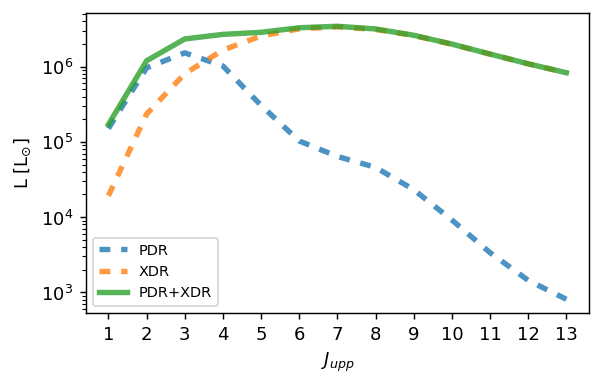

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
kwargs = {'lw': 3, 'alpha': 0.8}
Jupp = np.arange(Jmax) + 1

# baseline SLED
blSLED = gs.baseline_sled(galdf, gmcs, logLX, FUVparams, G0floor=G0floor, Jmax=Jmax)
ax.plot(Jupp, blSLED[0], label='PDR', ls=(0,(2,2)), **kwargs)
ax.plot(Jupp, blSLED[1], label='XDR', ls=(0,(2,2)), **kwargs)
ax.plot(Jupp, blSLED[2], label='PDR+XDR', **kwargs)

ax.set_yscale('log')
ax.legend(fontsize=8)
ax.set_xticks(Jupp)
ax.set_xlabel(r'$J_{upp}$')
ax.set_ylabel(r'L [L$_{\odot}$]');

<a id='fit'></a>

## Fit the baseline model to a observed CO SLED

### Input observed CO SLED, lower errors, upper errors, and upper limits

You should input the observed CO SLED, with the errors, upper limits and missing data as well, up to the `Jmax`-th line. The only accepted units are solar luminosities. You should prepare a list made of 4 arrays: the first with the observed luminosities, the second with the lower errors, the third with the upper errors, and the fourth containing only 0s and 1s, where 0 means that the observed point is detected and 1 means it is an upper limit: in this case (a upper limit) the observed luminosity (i.e. the data-point in the first array) should be the 3$\sigma$ upper limit, and the lower and upper errors will be used only for plotting purposes (I set the upper error as 0 and the lower error as 0.2 times the 3$\sigma$ upper limit which will be the length of the downward arrow).

In the below example, I have the log of the CO luminosities up to the CO(13-12) line (so `Jmax=13`), I put the relative errors (lower and upper), and the fourth array is made of `Jmax` 0s since I do not have upper limits

In [5]:
# ONLY ACCEPTED UNITS ARE SOLAR LUMINOSITIES
# all arrays must have the same length (13)
# `ulim` array has to contain 1 in case of non-detections, 0 in case of detections
# in case of upper limit, the first array has the corresponding 3sigma upper limit
# in case of upper limit, `lo` and `hi` values are only for plotting purposes (length of downward arrows)

coSLED = 10**np.array([5.24, 6.02, 6.44, 6.69, 6.83, 6.80, 
                       6.71, 6.62, 6.58, 6.40, 6.35, 6.20, 6.15])
coSLED_lo = np.array([0.15, 0.12, 0.15, 0.06, 0.06, 0.06, 
                      0.06, 0.07, 0.07, 0.07, 0.09, 0.10, 0.19]) * coSLED
coSLED_up = np.array([0.15, 0.12, 0.15, 0.06, 0.06, 0.06, 
                      0.06, 0.06, 0.07, 0.07, 0.09, 0.10, 0.20]) * coSLED
coSLED_ulim = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

obSLED = [coSLED, coSLED_lo, coSLED_up, coSLED_ulim]

### Plot the observed CO SLED

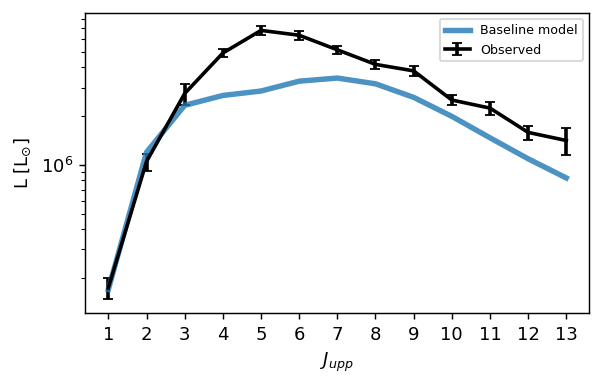

In [6]:
obSLED = [coSLED, coSLED_lo, coSLED_up, coSLED_ulim]

fig, ax = plt.subplots(1, 1, figsize=(5,3))
Jupp = np.arange(Jmax) + 1

ax.errorbar(Jupp, obSLED[0], color='k', capsize=3, lw=2,
            yerr = [obSLED[1], obSLED[2]], uplims = obSLED[3], label='Observed')
ax.plot(Jupp, blSLED[2], label='Baseline model', **kwargs)
ax.legend(fontsize=7)
ax.set_yscale('log')
ax.set_xticks(Jupp)
ax.set_xlabel(r'$J_{upp}$')
ax.set_ylabel(r'L [L$_{\odot}$]');

### Fit the observed CO SLED and plot all models

Here the Baseline model SLED produced by the code will be adapted to fit the observed CO SLED. The fit is performed with two free parameters:
- the X-ray attenuation column density $N_H$
- the CO-to-H$_2$ conversion factor $\alpha_{CO}$

Both parameters will be estimated by the `COfit` function and printed below. We will also plot the observed, Baseline model and Best-fit model CO SLEDs.

Since the errors on the CO data-points have a strong impact on the chi-square calculation, we can also set a minimum relative error with the `chi_thresh` parameter (e.g. `chi_thresh=0.15` will ignore any error - lower and upper - lesser than 0.15 times the observed luminosity, and set it to 0.15 times the observed luminosity)

#### Some clarifications on the best-fit parameters

The best-fit $N_H$ is a constant value throghout the whole galaxy, while in the Baseline model the column density varies with $r$ (in the above plot legend the median value $N_H^{med}$ is indicated). This is why the values of the two models can be equal, but not the corresponding SLEDs. The units of $N_H$ are always cm$^{-2}$.

The best-fit $\alpha_{CO}$ is defined relative to the Milky-Way value of $\alpha_{CO} = 4.3$ M$_{\odot}$ (K km s$^{-1}$ pc$^{2}$)$^{-1}$, which is the $\alpha_{CO}$ the input molecular gas mass `Mmol_tot` is assumed to have by default. If you input `Mmol_tot` calculated with another $\alpha_{CO}$, the Baseline model produced by the code will be consistent with it, but for the Best-fit model you have to edit the `alphaCOin` parameter in the `COfit` function input.

In [15]:
alphaCOin = 4.3     # this is the alphaCO of the Mmol_tot you input at the beginning
chi_thresh = 0.15   # the minimum relative error for the chi-square calculation

bestfit_params = gs.COfit(obSLED, galdf, gmcs, logLX, FUVparams, G0floor, alphaCOin, Jmax, chi_thresh)
print('logNH = %.2f\nalphaCO = %.2f\nreduced chi-square = %.2f' % bestfit_params)

logNH = 23.40
alphaCO = 4.30
reduced chi-square = 1.80


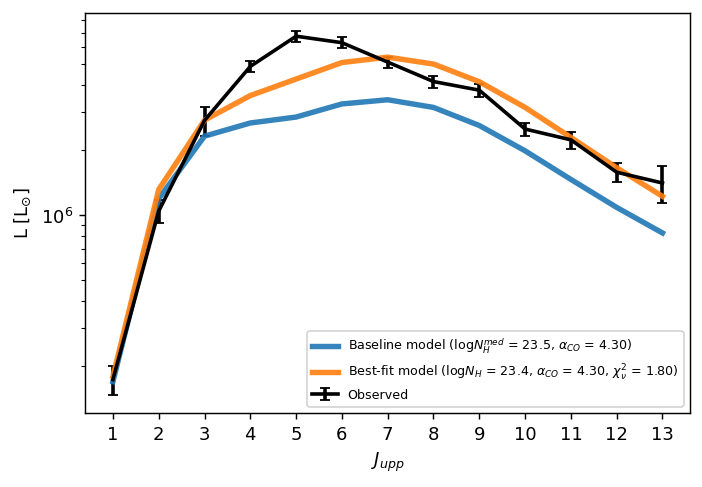

In [16]:
logNH, alphaCO, red_chi = bestfit_params

fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=130)
Jupp = np.arange(Jmax) + 1
kwargs = {'lw': 3, 'alpha': 0.9}

# observed SLED
ax.errorbar(Jupp, obSLED[0], color='k', capsize=3, lw=2,
            yerr = [obSLED[1], obSLED[2]], uplims = obSLED[3],
            label = 'Observed')

# baseline SLED
blSLED = gs.baseline_sled(galdf, gmcs, logLX, FUVparams, G0floor=G0floor, Jmax=Jmax)
logNHmed = np.log10(galdf.NH_r.median())
baselab = r'Baseline model (log$N_H^{med}$ = %.1f, $\alpha_{CO}$ = %.2f)' % (logNHmed, alphaCOin)
ax.plot(Jupp, blSLED[2], label=baselab, **kwargs)

# best-fit SLED
fitSLED = gs.baseline_sled(galdf, gmcs, logLX, FUVparams, flatNH=logNH, G0floor=G0floor, Jmax=Jmax)
fitlab = r'Best-fit model (log$N_H$ = %.1f, $\alpha_{CO}$ = %.2f, $\chi^2_{\nu}$ = %.2f)' % bestfit_params
ax.plot(Jupp, fitSLED[2]*alphaCO/alphaCOin, label=fitlab, **kwargs)

ax.set_yscale('log')
ax.legend(fontsize=7)
ax.set_xticks(Jupp)
ax.set_xlabel(r'$J_{upp}$')
ax.set_ylabel(r'L [L$_{\odot}$]');

### Fit the observed CO SLED with Monte Carlo Markov Chains (MCMC)

This is an alternative approach to the fit performed in the previous section. The code will need the initial parameters you put at the beginning of this notebook, the `galdf` DataFrame, and the observed CO SLED `obSLED`, which contains also errors and upper limits. It uses the `emcee` library ([link](https://emcee.readthedocs.io/en/stable/)), which should be installed together with `galaxysled`.

In [6]:
# import emcee to run the following blocks
import emcee

#### Things you may want to edit

In [7]:
# MCMC parameters (quick test values, while good values are commented)
nwalkers = 5 # 10
niter = 100 # 10000
niter_burnin = 50 # 5000

# fit parameters
alphaCOin = 4.3     # this is the alphaCO of the Mmol_tot you input at the beginning
chi_thresh = 0.15   # the minimum relative error for the chi-square calculation

#### Things you can keep as they are

Note: next cell can take some time to be executed

In [15]:
# turn off automatic NumPy parallelization
os.environ['OMP_NUM_THREADS'] = '1'

# set specific model data
logNHmed = np.log10(galdf.NH_r.median())
x = (galdf, gmcs, logLX, FUVparams, G0floor, Jmax, alphaCOin)
y, yerr, yulim = gs.SLED_errors(obSLED, thresh=chi_thresh)

# set specific MCMC parameters
data = (x, y, yerr, yulim)
initial = np.array([4.3, logNHmed if logNHmed >= 22. else 22.])
ndim = len(initial)
p0 = [np.array(initial) + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)]

# setup backend (to save results)
filename = '%sMCMC_results.h5' % outfolder
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# MCMC
print('MCMCing...')
sampler, pos, prob, state = gs.MCMC_main_parallel(p0, nwalkers, niter, niter_burnin, 
                                                  ndim, gs.MCMC_lnprob, data, backend=backend)
samples = sampler.flatchain
log_prob = sampler.flatlnprobability

# generate plots (optional)
gs.MCMC_plotter(samples, data, savepng=outfolder)
gs.MCMC_cornerplot(samples, ndim, savepng=outfolder)
gs.MCMC_spread_plotter(samples, log_prob, data, nsamples=100, plot_base=True, 
                       savepng=outfolder, plot_residuals=True)
gs.MCMC_plot_autocorr(sampler, savepng=outfolder)
gs.MCMC_plot_iterations(sampler, savepng=outfolder)

MCMCing...
Running burn-in...


100%|█████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.21it/s]


Running production...


100%|███████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]


#### Load MCMC results

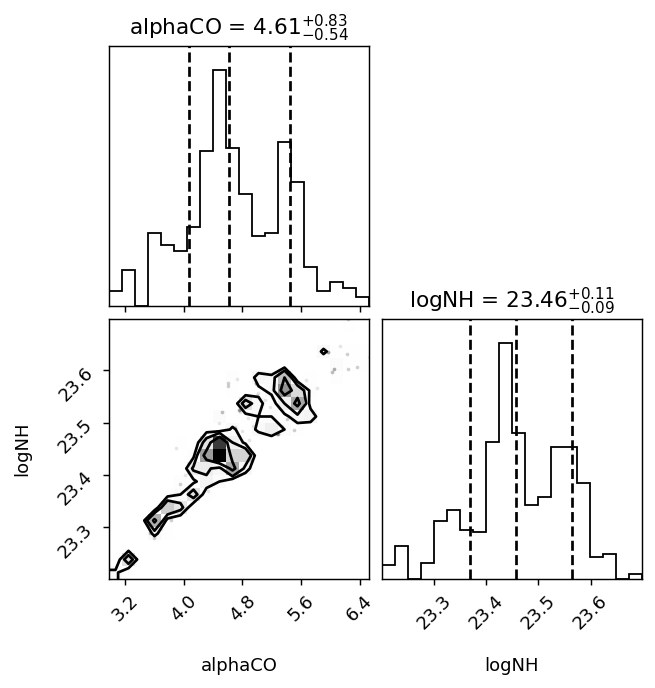

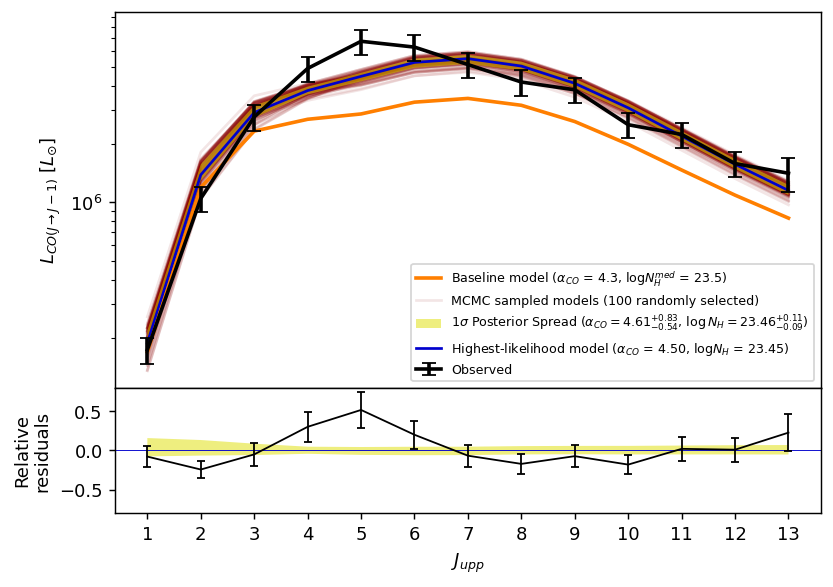

In [8]:
# input parameters
alphaCOin = 4.3     # this is the alphaCO of the Mmol_tot you input at the beginning
chi_thresh = 0.15   # the minimum relative error for the chi-square calculation
x = (galdf, gmcs, logLX, FUVparams, G0floor, Jmax, alphaCOin)
y, yerr, yulim = gs.SLED_errors(obSLED, thresh=chi_thresh)
data = (x, y, yerr, yulim)

# load results
filename = '%sMCMC_results.h5' % outfolder
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain()
samples = samples.reshape(-1, samples.shape[-1])
log_prob = reader.get_log_prob().flatten()
ndim = samples.shape[-1]

# generate plots
gs.MCMC_cornerplot(samples, ndim, savepng=None)
gs.MCMC_spread_plotter(samples, log_prob, data, nsamples=100, plot_base=True, 
                       savepng=None, plot_residuals=True)

#### More data from the MCMC output

The following cell plots the **highest-likelihood model** (blue line in the plot above), decomposed into its PDR and XDR components, against the observed CO SLED. This model is also the reference for calculating the residuals (see the plot above).

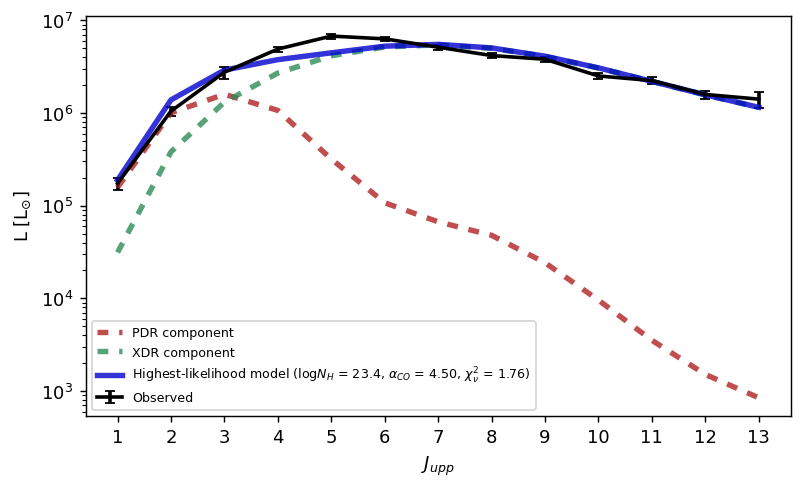

In [22]:
# input parameters
alphaCOin = 4.3     # this is the alphaCO of the Mmol_tot you input at the beginning
chi_thresh = 0.15   # the minimum relative error for the chi-square calculation
x = (galdf, gmcs, logLX, FUVparams, G0floor, Jmax, alphaCOin)
y, yerr, yulim = gs.SLED_errors(obSLED, thresh=chi_thresh)
data = (x, y, yerr, yulim)

# load results
filename = '%sMCMC_results.h5' % outfolder
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain()
samples = samples.reshape(-1, samples.shape[-1])
log_prob = reader.get_log_prob().flatten()
ndim = samples.shape[-1]

# highest likelihood model
theta_max = samples[np.argmax(log_prob)]
highest_lh_sled = gs.MCMC_model(theta_max, x)
chi_square, chi_square_reduced = gs.chi_sled(obSLED, highest_lh_sled[2], chi_thresh=chi_thresh, Nfree=2)

# plot
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
kwargs = {'lw': 3, 'alpha': 0.8}
hlm_params = (theta_max[1], theta_max[0], chi_square_reduced)
hlm_lab = r'Highest-likelihood model (log$N_H$ = %.1f, $\alpha_{CO}$ = %.2f, $\chi^2_{\nu}$ = %.2f)' % hlm_params
Jupp = np.arange(Jmax) + 1
ax.errorbar(Jupp, obSLED[0], color='k', capsize=3, lw=2,
            yerr = [obSLED[1], obSLED[2]], uplims = obSLED[3], label='Observed')
ax.plot(Jupp, highest_lh_sled[0], label='PDR component', ls=(0,(2,2)), color='firebrick', **kwargs)
ax.plot(Jupp, highest_lh_sled[1], label='XDR component', ls=(0,(2,2)), color='seagreen', **kwargs)
ax.plot(Jupp, highest_lh_sled[2], label=hlm_lab, color='mediumblue', **kwargs)
ax.set_yscale('log')
ax.legend(fontsize=7)
ax.set_xticks(Jupp)
ax.set_xlabel(r'$J_{upp}$')
ax.set_ylabel(r'L [L$_{\odot}$]');

***
<a id='gmcs'></a>

## APPENDIX A: available GMCs

The available GMCs are listed at the end of the `gmcs.py` module. Every single GMC is an instance of the `GMC` class, and is defined from its mass, radius, mean number density, Mach number, temperature, and number of clumps.

In [Esposito et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.8727E/abstract), we generated a list of 15 different GMCs, which make the `e24list`. The details of these GMCs are contained in the `resources/GMC_e24.csv` file, where every column is a GMC (and the column name is the GMC name). The file content (read as a pandas DataFrame) is also available with the `e24csv` command in galaxySLED:

In [26]:
gs.e24csv

,e24_logM31,e24_logM33,e24_logM35,e24_logM37,e24_logM39,e24_logM41,e24_logM43,e24_logM45,e24_logM47,e24_logM49,e24_logM51,e24_logM53,e24_logM55,e24_logM57,e24_logM59,units
logM,3.100,3.300,3.500,3.700,3.900,4.100,4.300,4.500,4.700,4.900,5.100,5.300,5.500,5.700,5.900,Msun
logR,0.186,0.286,0.386,0.486,0.586,0.686,0.786,0.886,0.986,1.086,1.186,1.286,1.386,1.486,1.586,pc
logn0,3.440,3.340,3.240,3.140,3.040,2.940,2.840,2.740,2.640,2.540,2.440,2.340,2.240,2.140,2.040,cm^-3
logSigma,2.230,2.230,2.230,2.230,2.230,2.230,2.230,2.230,2.230,2.230,2.230,2.230,2.230,2.230,2.230,Msun.pc^-2
Mach,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,Mach
Temp,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,K
Nclumps,69.000,94.000,116.000,164.000,241.000,348.000,452.000,674.000,935.000,1356.000,1897.000,2677.000,3743.000,5357.000,7644.000,clumps


For every GMC, in the `resources` directory, there is a PDR and a XDR file. In these files, every column is a molecular line, and every row is a different incident flux. To get these files, you should navigate within the galaxySLED package directory: you can find it by typing `os.path.dirname(gs.__file__)`. Or you can download the directory from the [galaxySLED GitHub](https://github.com/federicoesposito/galaxySLED).

This is, for example, the PDR file for the median GMC of the distribution `e24_logM45` (units are solar luminosities):

In [18]:
e24_logM45_PDR = pd.read_csv(os.path.dirname(gs.__file__) + '/resources/GMC_e24_logM45_PDR.csv', index_col=0)
e24_logM45_PDR

,CO1,CO2,CO3,CO4,CO5,CO6,CO7,CO8,CO9,CO10,...,CO21,CO22,CO23,CO24,CO25,CO26,CO27,CO28,CO29,CO30
g000,0.298606,1.640588,2.035788,0.959969,0.155612,0.020243,0.006554,0.003471,0.002117,0.001154,...,5.130961e-07,2.280993e-07,1.009640e-07,4.473653e-08,2.001038e-08,9.414573e-09,4.837215e-09,2.810781e-09,1.863865e-09,1.371137e-09
g025,0.238096,1.345253,1.730272,0.854037,0.153529,0.024970,0.008076,0.003654,0.002017,0.001087,...,7.465079e-07,3.663024e-07,1.833616e-07,9.474822e-08,5.128267e-08,2.988737e-08,1.899980e-08,1.317707e-08,9.853388e-09,7.777465e-09
g050,0.190553,1.105658,1.468877,0.756262,0.148674,0.029008,0.010281,0.004348,0.002045,0.001014,...,1.057295e-06,5.973945e-07,3.549424e-07,2.222862e-07,1.464566e-07,1.013951e-07,7.318028e-08,5.464991e-08,4.199171e-08,3.300680e-08
g075,0.152808,0.907854,1.238597,0.666516,0.141726,0.031715,0.012143,0.004965,0.002052,0.000932,...,1.480860e-06,9.306917e-07,6.166914e-07,4.276676e-07,3.077673e-07,2.283006e-07,1.733196e-07,1.339447e-07,1.050993e-07,8.349646e-08
g100,0.120666,0.733767,1.038212,0.583044,0.131680,0.031460,0.012722,0.005431,0.002119,0.000870,...,2.032257e-06,1.433420e-06,1.065848e-06,8.235593e-07,6.537331e-07,5.277301e-07,4.307577e-07,3.537854e-07,2.918525e-07,2.410337e-07
g125,0.097350,0.602802,0.879014,0.509004,0.120595,0.028997,0.011491,0.004893,0.001873,0.000738,...,2.522650e-06,1.934609e-06,1.553546e-06,1.285244e-06,1.083931e-06,9.229065e-07,7.903259e-07,6.780160e-07,5.820397e-07,4.983495e-07
g150,0.080531,0.504891,0.746914,0.444511,0.109992,0.026281,0.010209,0.004368,0.001633,0.000608,...,2.663080e-06,2.138590e-06,1.787345e-06,1.530465e-06,1.330213e-06,1.163293e-06,1.020663e-06,8.953516e-07,7.844720e-07,6.844300e-07
g175,0.065553,0.417197,0.627204,0.388348,0.100015,0.023231,0.008385,0.003320,0.001199,0.000435,...,2.363957e-06,1.968100e-06,1.692670e-06,1.482533e-06,1.312341e-06,1.165155e-06,1.035705e-06,9.190496e-07,8.134855e-07,7.163679e-07
g200,0.052421,0.338685,0.523902,0.339538,0.091042,0.020657,0.006992,0.002605,0.000922,0.000319,...,1.846573e-06,1.604915e-06,1.424509e-06,1.276558e-06,1.149496e-06,1.034124e-06,9.290987e-07,8.319063e-07,7.421185e-07,6.580716e-07
g225,0.042520,0.277886,0.442348,0.297467,0.082992,0.018458,0.005956,0.002147,0.000756,0.000247,...,1.335143e-06,1.208562e-06,1.102681e-06,1.007038e-06,9.190919e-07,8.351816e-07,7.563074e-07,6.816330e-07,6.114923e-07,5.449328e-07


***
<a id='slope'></a>

## APPENDIX B: check the slope of the GMC fill-up procedure

Once you used the `gmc_fill` function to fill a galaxy with GMCs, you may want to check if the proposed power-law distribution of the GMC masses has the same index you input (e.g. $a=1.64$). To do so, we prepared the below function `slope_check`

In [19]:
from scipy.stats import linregress
def slope_check(galdf, gmcs, a):
    '''
    Plot the slope of the generated GMC mass power-law distribution
    It is useful to check it against the predicted a value (plotted with a dashed line)
    It can only calculate the slope for rings where there is at least 1 GMC of every mass
    '''
    gmcCounts = [galdf.loc[i, galdf.columns[3:-4]].to_numpy() for i in galdf.index]
    gmcMasses = np.array([gmc.M for gmc in gmcs])
    slopes = []
    for i in galdf.index:
        slopes.append(linregress(np.log10(gmcMasses), np.log10(gmcCounts[i]))[0])
    slope = - linregress(np.log10(gmcMasses), np.log10(sum(gmcCounts)))[0]
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=130)
    ax.scatter(galdf.r, -np.array(slopes), s=80, edgecolors='k')
    ax.axhline(slope, c='green', lw=2, alpha=.8)
    ax.axhline(a, c='k', ls=(0,(5,5)), alpha=.7)
    ax.set_xscale('log')
    ax.set_xlabel('r [pc]')
    ax.set_ylabel('Slope');

/tmp/ipykernel_27921/1838862663.py:12: RuntimeWarning: divide by zero encountered in log10
  slopes.append(linregress(np.log10(gmcMasses), np.log10(gmcCounts[i]))[0])
/media/phd/hub/packaging/py312testenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2842: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


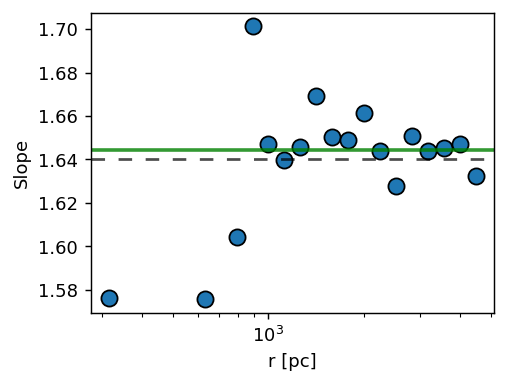

In [20]:
outfolder = './ngc7469/'
gmcs = gs.e24list
a = 1.64
galdf = pd.read_csv(outfolder + 'GMCs_Nradii74_a164.csv', index_col=0)
slope_check(galdf, gmcs, a)